# import, set sampler

In [1]:
import numpy as np
import dwave.inspector
from dwave.system import DWaveSampler
import pickle
import pandas as pd
from pathlib import Path  
from datetime import datetime
import matplotlib.pyplot as plt
import os

In [2]:
f1 = open("../token.txt", "r")
f2 = open("../paid_token.txt", "r")
freetoken=f1.read()
paidtoken=f2.read()

sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=freetoken)
# sampler = DWaveSampler(solver=dict(topology__type='zephyr'),token=paidtoken)

print("QPU {} was selected.".format(sampler.solver.name))

QPU Advantage2_prototype1.1 was selected.


# shimming

In [3]:
#a random problem instance
zero_h = {v: 0.0 for v in sampler.nodelist}
choices_J = [-1, 0.9]
#choices_J = [-1, 0, 1]
zero_J = {tuple(c): 0.0 for c in sampler.edgelist}


In [4]:
def qub_mags(hbias, Nreads):

    anneal_pause_quench_sch = [[0.0, 0.0], [1.0, 1]]

    response =  sampler.sample_ising(
                h=zero_h,
                J=zero_J,
                anneal_schedule=anneal_pause_quench_sch,
                num_reads=Nreads,
                flux_drift_compensation=False,
                flux_biases=hbias, 
                answer_mode = 'raw',
                readout_thermalization=100.,
                auto_scale=False)
  
             
    #number of runs in resp
    Nruns=response.record.shape[0]
    #make a list of qubits used
    qubitl=[]
    for qubit in response.variables:
        qubitl.append(qubit)
    #calculate the magnetization of each qubit over all runs
    #and make a magnetization list
    magl=[]
    for i in range(len(qubitl)):
        #list of spins from all runs for qubiti
        spinl=[]
        for run in range(Nruns):
            spin=response.record[run][0][i]
            spinl.append(spin)
        avgspin=(sum(spinl))/(len(spinl))
        magl.append(avgspin)
        
    qm_ar=np.array([qubitl,magl])
    #this is the magnetization, averaged first over all runs for individual sites,
    #and then averaged over all sites
    avg_m=np.mean(qm_ar[1])
    stdev_m=np.std(qm_ar[1])

    
#     dwave.inspector.show(resp)
    
    #return qm_ar,avg_m,stdev_m
    return qm_ar

In [5]:
hbias = [0] * sampler.properties['num_qubits']
qm_ar = qub_mags(hbias, 1000)

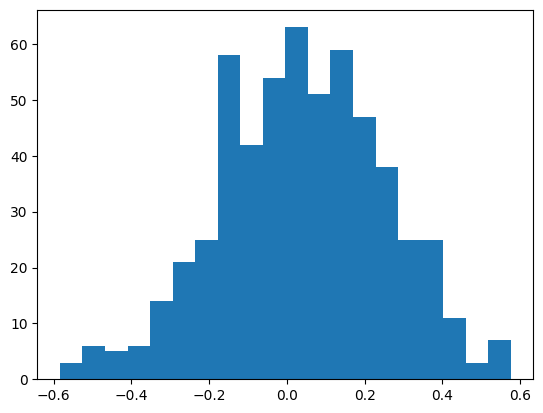

In [6]:
plt.hist(qm_ar[1], bins = 20)
plt.show()

In [128]:
alpha = float(2e-5)
#hbias = [0] * sampler.properties['num_qubits']
count2 = 0
for node in range(sampler.properties['num_qubits']):
    if node in nodes_class:
        hbias[node] += (-alpha)*qm_ar[1][count2]
        count2 += 1

(array([ 2., 11., 14., 57., 56., 57., 42., 25., 11.,  1.]),
 array([-0.636 , -0.5066, -0.3772, -0.2478, -0.1184,  0.011 ,  0.1404,
         0.2698,  0.3992,  0.5286,  0.658 ]),
 <BarContainer object of 10 artists>)

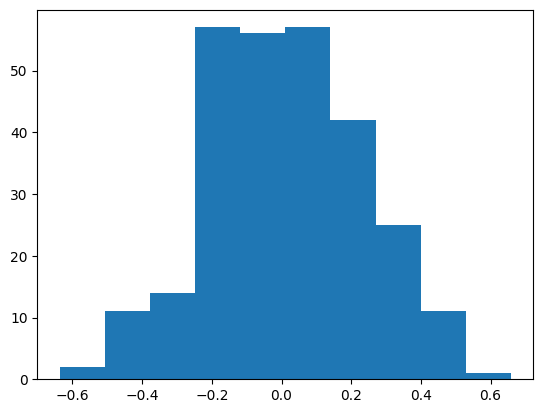

In [129]:
qm_ar = qub_mags(0, hbias, 1000, 1.0)
plt.hist(qm_ar[1])

In [10]:
#Nrep is repetitions of calibration
#Nreads is anneals per repetition
def new_flux_cal(Nreads, alpha, Nrep, hbias):
    
    #intialize the lists of mi and hiflux
    #for the first run this will be 
    mi=mi_init
    hifluxl=hbias
    
    flux_list_Nrep=[]
    mi_list_Nrep=[]
    
    
    for count in range(Nrep):
        if count < 10:
            shim = 0.
        else:
            shim = alpha

        q_mags=qub_mags(hifluxl, Nreads)
        mi=q_mags[1]
        
        flux_list_Nrep.append(hifluxl)
        mi_list_Nrep.append(mi)
        
        #hifluxl = [0] * sampler.properties['num_qubits']
        count2 = 0
        modifications = np.zeros(len(hifluxl))
        for node in range(sampler.properties['num_qubits']):
            if node in zero_h:
                modifications[node] = (-shim)*mi[count2]
                count2 += 1
        hifluxl = hifluxl + modifications
        print("done with ", count)

    return flux_list_Nrep, mi_list_Nrep

In [12]:
hbias = [0] * sampler.properties['num_qubits']
#hbias = array_flux[-1]
alpha = float(3e-6)
array_flux, array_mi = new_flux_cal(100, alpha, 100, hbias)

done with  0
done with  1
done with  2
done with  3
done with  4
done with  5
done with  6
done with  7
done with  8
done with  9
done with  10
done with  11
done with  12
done with  13
done with  14
done with  15
done with  16
done with  17
done with  18
done with  19
done with  20
done with  21
done with  22
done with  23
done with  24
done with  25
done with  26
done with  27
done with  28
done with  29
done with  30
done with  31
done with  32
done with  33
done with  34
done with  35
done with  36
done with  37
done with  38
done with  39
done with  40
done with  41
done with  42
done with  43
done with  44
done with  45
done with  46
done with  47
done with  48
done with  49
done with  50
done with  51
done with  52
done with  53
done with  54
done with  55
done with  56
done with  57
done with  58
done with  59
done with  60
done with  61
done with  62
done with  63
done with  64
done with  65
done with  66
done with  67
done with  68
done with  69
done with  70
done with  71
do

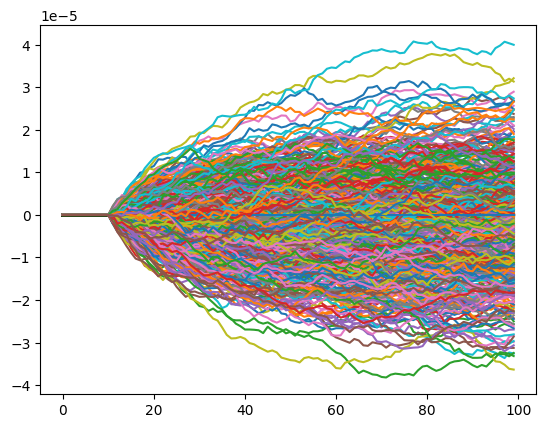

In [13]:
for k in range(len(array_flux[0])):
    flux_qubit = np.ones(len(array_flux))
    for i in range(len(array_flux)):
        flux_qubit[i] = array_flux[i][k]
    plt.plot(flux_qubit)

<ErrorbarContainer object of 3 artists>

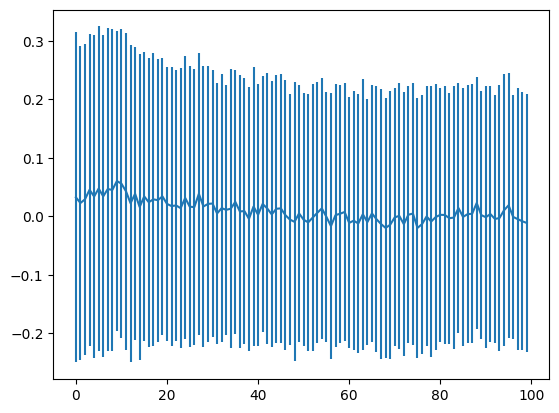

In [14]:
avg_v = []
std_v = []
for i in range(len(array_mi)):
    avg_v.append(np.mean(array_mi[i]))
    std_v.append(np.std(array_mi[i]))
plt.errorbar(range(len(array_flux)), avg_v, yerr = std_v)

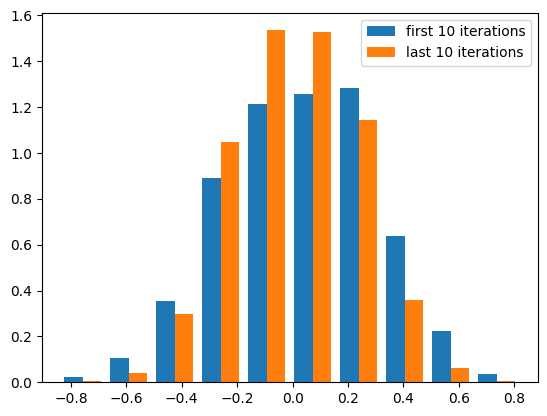

In [20]:
first_ten = np.array(array_mi[1:10]).flatten()
last_ten = np.array(array_mi[-9:]).flatten()
plt.hist([first_ten, last_ten], label = ['first 10 iterations', 'last 10 iterations'], density = True)
# plt.hist(last_ten, label = 'final 10 iterations', density = True)
plt.legend()

In [234]:
print(np.std(first_ten), np.std(last_ten))

0.2831770035831397 0.21919144763065215


In [186]:
np.std(last_ten)

0.31941717881319875

# time estimate

In [23]:

times_big = []

for h1_run in hlist:

    h1val = h1_run
    times = []
        
    for j in range(len(splist)):
        sp = splist[j]
#         print("sp=",sp)
        spindex = find_nearest(new_s, sp)
        jafm = 1.0/np.max(J22_s)
        k2 = -2.0


        #set js
        final_coups={}
        for coup in coups_class:
            if coups_class[coup]=='K2':
                final_coups.update({coup:k2})
            elif coups_class[coup]=='J11':
                final_coups.update({coup:jafm})
            elif coups_class[coup]=='J12':
                final_coups.update({coup:J12_s[spindex]/np.max(J22_s)})
            elif coups_class[coup]=='J22':
                final_coups.update({coup:J22_s[spindex]/np.max(J22_s)})
            else:
                print("error")


        #set hs and anneal offsets
        offsets = [0] * sampler.properties['num_qubits']
        offset = delta_c[spindex]

        hmod_edgeA=0.5
        hmod_edgeB=0.5
        hmod_BSE=1

        final_hs={}
        for node in nodes_class:
            index = node
            #these are onechains. They don't get any hoffset or anneal offset
            if nodes_class[node]=="BUL1":
                final_hs.update({node:h1val})
            elif nodes_class[node]=="BSE1":
                final_hs.update({node: hmod_BSE * h1val})
            elif nodes_class[node]=="EB1":
                final_hs.update({node: hmod_edgeB * h1val})

            #these are twochains. They get hoffsets and anneal offsets
            elif nodes_class[node]=="BUL2":
                final_hs.update({node: hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EA2":
                final_hs.update({node: hmod_edgeA * hoffset_s[spindex] * h1val})
                offsets[index] = offset
            elif nodes_class[node]=="EB2":
                final_hs.update({node: hmod_edgeB * hoffset_s[spindex] * h1val})
                offsets[index] = offset

            else:
                print("error")
                
            final_nodes=sorted(list(final_hs.keys()))

        
        
        # reverse quench - pause - forward quench
        #rev_sch = [[0.0, 1.0], [(1 - sp), sp], [(1 - sp) + tpause, sp],
        #           [2 * (1 - sp) + tpause, 1]]

        anneal_pause_quench_sch = [[0.0, 0.0], [1000*sp, sp], [100 + 1000*sp, sp],
                    [100 + 1000*sp + (1-sp), 1]]
                    
        time_allreps=[]
        for rep in range(Nreps):                
            time =  sampler.solver.estimate_qpu_access_time(
                    num_qubits=len(final_nodes),
                    anneal_schedule=anneal_pause_quench_sch,
                    num_reads=Nreads,
                    answer_mode = "raw")
            
            if time > 1000000:
                    print("time for Nreads=", Nreads, "is more than 1 second:",
                            time)
            time_allreps.append(time)

                
        times.append(sum(time_allreps))
        #print("s_p=", sp, "time=", sum(time_allreps))
    print("h1=", h1val, "time=", sum(times))
    times_big.append(sum(times))
    print("")
print("anneal pause quench anneal access time", sum(times_big) / 1000000, "seconds", sum(times_big) / 1000000 /60, "minutes")
print("all done")

h1= 0.0 time= 6797206.771678052

h1= 0.16534254240962615 time= 6797206.771678052

h1= 0.3306850848192523 time= 6797206.771678052

h1= 0.49602762722887844 time= 6797206.771678052

h1= 0.6613701696385046 time= 6797206.771678052

h1= 0.8267127120481308 time= 6797206.771678052

h1= 0.9920552544577569 time= 6797206.771678052

h1= 1.157397796867383 time= 6797206.771678052

h1= 1.3227403392770092 time= 6797206.771678052

anneal pause quench anneal access time 61.174860945102466 seconds 1.0195810157517078 minutes
all done


# anneal pause quench

In [26]:

h1val = 0.0
jafm = 1.0/np.max(J22_s)
k2 = -2.0
sp = 0.7
spindex = find_nearest(new_s, sp)
print("start s_p=", sp)
print("h/J = ", h1val/jafm)



#set js
final_coups={}
for coup in coups_class:
    if coups_class[coup]=='K2':
        final_coups.update({coup:k2})
    elif coups_class[coup]=='J11':
        final_coups.update({coup:jafm})
    elif coups_class[coup]=='J12':
        final_coups.update({coup:J12_s[spindex] * jafm})
    elif coups_class[coup]=='J22':
        final_coups.update({coup:J22_s[spindex] * jafm})
    else:
        print("error")


#set hs and anneal offsets
offsets = [0] * sampler.properties['num_qubits']
offset = delta_c[spindex]

hmod_edgeA=0.5
hmod_edgeB=0.5
hmod_BSE=1

final_hs={}
for node in nodes_class:
    index = node
    #these are onechains. They don't get any hoffset or anneal offset
    if nodes_class[node]=="BUL1":
        final_hs.update({node:h1val})
    elif nodes_class[node]=="BSE1":
        final_hs.update({node: hmod_BSE * h1val})
    elif nodes_class[node]=="EB1":
        final_hs.update({node: hmod_edgeB * h1val})

    #these are twochains. They get hoffsets and anneal offsets
    elif nodes_class[node]=="BUL2":
        final_hs.update({node: hoffset_s[spindex] * h1val})
        offsets[index] = offset
    elif nodes_class[node]=="EA2":
        final_hs.update({node: hmod_edgeA * hoffset_s[spindex] * h1val})
        offsets[index] = offset
    elif nodes_class[node]=="EB2":
        final_hs.update({node: hmod_edgeB * hoffset_s[spindex] * h1val})
        offsets[index] = offset

    else:
        print("error")

    final_nodes=sorted(list(final_hs.keys()))




anneal_pause_quench_sch = [[0.0, 0.0], [1000*sp, sp], [100 + 1000*sp, sp],
            [100 + 1000*sp + (1-sp), 1]]


#         for rep in range(Nreps): 

#             response =  sampler.sample_ising(
#                         h=final_hs,
#                         J=final_coups,
#                         anneal_schedule=anneal_pause_quench_sch,
#                         num_reads=Nreads,
#                         anneal_offsets = offsets)

#             time = response.info['timing']['qpu_access_time']
        
# #             time =  sampler.solver.estimate_qpu_access_time(
# #                 num_qubits=len(final_nodes),
# #                 anneal_schedule=anneal_pause_quench_sch,
# #                 num_reads=Nreads,
# #                 answer_mode = "raw")

#             time_allreps.append(time)

#             folder = Path(
#                "/Users/prathunarasimhan/Desktop/APQ extra/raw"
#                 + "/" + "h1=" + str(h1val) 
#                 + "/" + "s=" + str(sp))
#             folder.mkdir(parents=True, exist_ok=True)


#             Name = DocName(jafm, k2, h1val, sp) + "_" + str(rep)
#             filepath = Path(folder, Name)



#             paramsarray = set_params_array({
#                     'jafm': jafm,
#                     'k2': k2,
#                     'h1': h1val,
#                     'Nreads': Nreads,
#                     'sp' : sp
#                 })

#             resp = response.record
#             np.savez(
#             filepath,
#             resp=resp,
#             paramsarray=paramsarray,
#             final_nodes=final_nodes,
#             )


#         times.append(sum(time_allreps))
#         print("s_p=", sp, "time=", sum(time_allreps))
#     print("h1=", h1val, "time=", sum(times))
#     times_big.append(sum(times))
#     print("")
# print("")
# print("")
# print("")
# print("anneal pause quench anneal access time", sum(times_big) / 1000000, "seconds", sum(times_big) / 1000000 /60, "minutes")
# print("all done")

start s_p= 0.7
h/J =  0.0


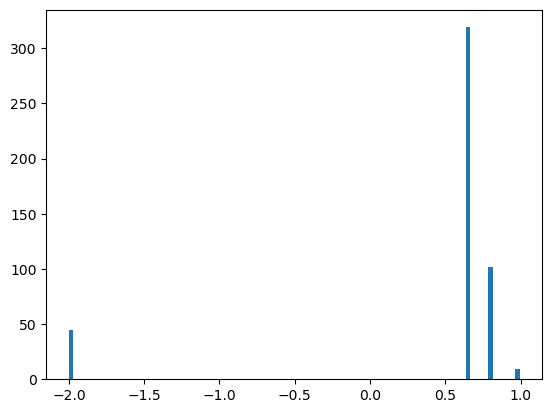

In [41]:
plt.hist(list(final_coups.values()), bins = 100)
plt.show()